# GLOBAL TERRORISM - THE EVOLUTION OF TERRORIST ATTACKS IN THE LAST 20 YEARS

## SPARK - Individual Assignment
## Eleonora Jiménez Pulido

Information extracted from https://www.kaggle.com/START-UMD/gtd 

The global terrorism database records information on more than 180,000 Terrorist Attacks around the world from 1970 through 2017. For more information on the dataset and its columns you can go to https://www.kaggle.com/START-UMD/gtd  or https://www.start.umd.edu/research-projects/global-terrorism-database-gtd.


# Table of Contents

* [1. Data source and Spark data abstraction (DataFrame) setup](#1)
* [2. Data set metadata analysis](#2)
* [3. Columns groups basic profiling to better understand our data set](#3)
* [4. Business Questions](#4)
 * [4.1. Has the world become a more violent place in the last 20 years?](#4.1)
 * [4.2. How have terrorist attacks evolved in the past 20 years in each region?](#4.2)
 * [4.3.  Throughout the years, does it seem to have been a switch in the type of attacks the world has experienced?](#4.3.)
 * [4.4. Have attacks become more lethal?](#4.4.)
 * [4.5. Do different regions have different type of attack?](#4.5)

In [1]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:100% !important; }</style>")) # Increase cell width
display(HTML("<style>.rendered_html { font-size: 14px; }</style>")) # Increase font size

In [19]:
import sys
!{sys.executable} -m pip install seaborn

    100% |████████████████████████████████| 286kB 2.6MB/s ta 0:00:01
    100% |████████████████████████████████| 25.9MB 32kB/s  eta 0:00:01


In [1]:
import findspark
findspark.init()

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

from IPython.display import display, Markdown
from pyspark.sql.functions import when, count, col, countDistinct, desc, first, lit, sum, count, round
import pyspark.sql.functions as f
from pyspark.sql.types import *
from pyspark.sql.window import Window

#libraries to implement the charts
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas 
import numpy as np
import seaborn as sns


sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

## 1. Data source and Spark data abstraction setup
<a id='1'></a>

In [2]:
TerrorismDF = spark.read \
                 .option("inferSchema", "true") \
                 .option("header", "true") \
                 .option("multiline", "true") \
                 .option("quote", '"') \
                 .option("delimiter", ',') \
                 .option("escape", "\\") \
                 .option("escape", '"') \
                 .csv("globalterrorismdb_0718dist.csv")


## 2. Data set metadata analysis
<a id='2'></a>

### 2.1. Subset Dataset and rename Columns
<a id='2.1'></a>

In [3]:
TerrorismDF = TerrorismDF.filter(TerrorismDF["iyear"]>1996)

#Rename the columns to have more friendly names
TerrorismDF = TerrorismDF.withColumnRenamed('iyear', 'year')\
                         .withColumnRenamed('imonth', 'month')\
                         .withColumnRenamed('country', 'countryid')\
                         .withColumnRenamed('region', 'regionid')\
                         .withColumnRenamed('country_txt', 'country')\
                         .withColumnRenamed('region_txt', 'region')\
                         .withColumnRenamed('attacktype1_txt', 'AttackType')

### 2.2. Display schema and size of the DataFrame
<a id='2.2'></a>

In [4]:
TerrorismDF.printSchema()
display(Markdown("This DataFrame has **%d rows**." % TerrorismDF.count()))

root
 |-- eventid: long (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- iday: integer (nullable = true)
 |-- approxdate: string (nullable = true)
 |-- extended: integer (nullable = true)
 |-- resolution: string (nullable = true)
 |-- countryid: integer (nullable = true)
 |-- country: string (nullable = true)
 |-- regionid: integer (nullable = true)
 |-- region: string (nullable = true)
 |-- provstate: string (nullable = true)
 |-- city: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- specificity: integer (nullable = true)
 |-- vicinity: integer (nullable = true)
 |-- location: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- crit1: integer (nullable = true)
 |-- crit2: integer (nullable = true)
 |-- crit3: integer (nullable = true)
 |-- doubtterr: integer (nullable = true)
 |-- alternative: integer (nullable = true)
 |-- alternative_txt: string (nullable 

This DataFrame has **117381 rows**.

## 3. Columns groups basic profiling to better understand our dataset
<a id='3'></a>

### 3.1. Basic profiling for columns with time related information
<a id='3.1'></a>

In [5]:
print ("Summary of columns Year and Month:")
TerrorismDF.select("year","month").summary().show()

print("Checking for nulls on columns Year and Month:")
TerrorismDF.select([count(when(col(c).isNull(), c)).alias(c) for c in ["year","month"]]).show()

print("Checking amount of distinct values in columns Year and Month:")
TerrorismDF.select([countDistinct(c).alias(c) for c in ["year","month"]]).show()

print ("Most and least frequent occurrences for Year and Month columns:")
YearOccurrencesDF = TerrorismDF.groupBy("year").agg(count(lit(1)).alias("Total"))
MonthDF = TerrorismDF.groupBy("month").agg(count(lit(1)).alias("Total"))

leastFreqYear   = YearOccurrencesDF.orderBy(col("Total").asc()).first()
mostFreqYear    = YearOccurrencesDF.orderBy(col("Total").desc()).first()
leastFreqMonth  = MonthDF.orderBy(col("Total").asc()).first()
mostFreqMonth   = MonthDF.orderBy(col("Total").desc()).first()

display(Markdown("""
| %s | %s | %s | %s |
|----|----|----|----|
| %s | %s | %s | %s |
""" % ("leastFreqYear", "mostFreqYear", "leastFreqMonth", "mostFreqMonth", \
       "%d (%d occurrences)" % (leastFreqYear["year"], leastFreqYear["Total"]), \
       "%d (%d occurrences)" % (mostFreqYear["year"], mostFreqYear["Total"]), \
       "%d (%d occurrences)" % (leastFreqMonth["month"], leastFreqMonth["Total"]), \
       "%d (%d occurrences)" % (mostFreqMonth["month"], mostFreqMonth["Total"]))))


Summary of columns Year and Month:
+-------+------------------+------------------+
|summary|              year|             month|
+-------+------------------+------------------+
|  count|            117381|            117381|
|   mean|2011.5615729973335| 6.472810761537216|
| stddev| 5.094113607868744|3.3825629001190003|
|    min|              1997|                 1|
|    25%|              2009|                 4|
|    50%|              2013|                 6|
|    75%|              2015|                 9|
|    max|              2017|                12|
+-------+------------------+------------------+

Checking for nulls on columns Year and Month:
+----+-----+
|year|month|
+----+-----+
|   0|    0|
+----+-----+

Checking amount of distinct values in columns Year and Month:
+----+-----+
|year|month|
+----+-----+
|  21|   12|
+----+-----+

Most and least frequent occurrences for Year and Month columns:



| leastFreqYear | mostFreqYear | leastFreqMonth | mostFreqMonth |
|----|----|----|----|
| 1998 (934 occurrences) | 2014 (16903 occurrences) | 12 (8633 occurrences) | 5 (10821 occurrences) |


### 3.2. Basic profiling for the main columns with attack related information
<a id='3.2'></a>

In [6]:
print ("Summary of columns country, Region,  Success, attack type, gName, Motive, crit1:")
TerrorismDF.select("country", "region", "success", "AttackType",'crit1').summary().show()
TerrorismDF.select("gname", "motive").summary().show()

print("Checking for nulls on columns country, Region, Success, attack type, attack type name, gName, Motive, crit1:")
TerrorismDF.select([count(when(col(c).isNull(), c)).alias(c) \
                    for c in ["countryid","country","regionid","region", "success", "attacktype1", "AttackType","gname", "motive",'crit1']]).show()

print("Checking amount of distinct values in columns country, Region, Success,  attack type, attack type name,  gName, Motive:")
TerrorismDF.select([countDistinct(c).alias(c) for c in ["countryid","country","regionid","region", "success", "attacktype1", "AttackType",\
                                                        "gname", "motive"]]).show()

# we omit the success column because it is boolean values
print ("Most and least frequent occurrences for country, Region, attacktype1, gName, Motive:")
CountryDF         = TerrorismDF.groupBy("countryid").agg(count(lit(1)).alias("Total"))
CountryNameDF     = TerrorismDF.groupBy("country").agg(count(lit(1)).alias("Total"))
RegionDF          = TerrorismDF.groupBy("regionid").agg(count(lit(1)).alias("Total"))
RegionNameDF      = TerrorismDF.groupBy("region").agg(count(lit(1)).alias("Total"))
AttackTypeDF      = TerrorismDF.groupBy("attacktype1").agg(count(lit(1)).alias("Total"))
AttackTypeNameDF  = TerrorismDF.groupBy("AttackType").agg(count(lit(1)).alias("Total"))
gNameDF           = TerrorismDF.groupBy("gname").agg(count(lit(1)).alias("Total"))
MotiveDF          = TerrorismDF.groupBy("motive").agg(count(lit(1)).alias("Total")) 

leastFreqCountry        = CountryDF.orderBy(col("Total").asc()).first()
mostFreqCountry         = CountryDF.orderBy(col("Total").desc()).first()
leastFreqCountryNm      = CountryNameDF.orderBy(col("Total").asc()).first()
mostFreqCountryNm       = CountryNameDF.orderBy(col("Total").desc()).first()
leastFreqRegion         = RegionDF.orderBy(col("Total").asc()).first()
mostFreqRegion          = RegionDF.orderBy(col("Total").desc()).first()
leastFreqRegionNm       = RegionNameDF.orderBy(col("Total").asc()).first()
mostFreqRegionNm        = RegionNameDF.orderBy(col("Total").desc()).first()
leastFreqAttackType     = AttackTypeDF.orderBy(col("Total").asc()).first()
mostFreqAttackType      = AttackTypeDF.orderBy(col("Total").desc()).first()
leastFreqAttackTypeNm   = AttackTypeNameDF.orderBy(col("Total").asc()).first()
mostFreqAttackTypeNm    = AttackTypeNameDF.orderBy(col("Total").desc()).first()
leastFreqGroupName      = gNameDF.orderBy(col("Total").asc()).first()
mostFreqGroupName       = gNameDF.orderBy(col("Total").desc()).first()
leastFreqMotive         = MotiveDF.orderBy(col("Total").asc()).first()
mostFreqMotive          = MotiveDF.orderBy(col("Total").desc()).first()

display(Markdown("""
| %s | %s | %s | %s | %s | %s |
|----|----|----|----|----|----|
| %s | %s | %s | %s | %s | %s |
""" % ("least Freq Country", "most Freq Country", "least Freq Region", "most Freq Region","least Freq AttackType", "most Freq AttackType", \
       "%d (%d occurrences)" % (leastFreqCountry["countryid"], leastFreqCountry["Total"]), \
       "%d (%d occurrences)" % (mostFreqCountry["countryid"], mostFreqCountry["Total"]), \
       "%s (%d occurrences)" % (leastFreqRegion["regionid"], leastFreqRegion["Total"]), \
       "%s (%d occurrences)" % (mostFreqRegion["regionid"], mostFreqRegion["Total"]), \
       "%s (%d occurrences)" % (leastFreqAttackType["attacktype1"], leastFreqAttackType["Total"]), \
       "%s (%d occurrences)" % (mostFreqAttackType["attacktype1"], mostFreqAttackType["Total"]))))

display(Markdown("""
| %s | %s | %s | %s | %s | %s |
|----|----|----|----|----|----|
| %s | %s | %s | %s | %s | %s |
""" % ("least Freq Country", "most Freq Country", "least Freq Region", "most Freq Region","least Freq AttackType", "most Freq AttackType", \
       "%s (%d occurrences)" % (leastFreqCountryNm["country"], leastFreqCountryNm["Total"]), \
       "%s (%d occurrences)" % (mostFreqCountryNm["country"], mostFreqCountryNm["Total"]), \
       "%s (%d occurrences)" % (leastFreqRegionNm["region"], leastFreqRegionNm["Total"]), \
       "%s (%d occurrences)" % (mostFreqRegionNm["region"], mostFreqRegionNm["Total"]), \
       "%s (%d occurrences)" % (leastFreqAttackTypeNm["AttackType"], leastFreqAttackTypeNm["Total"]), \
       "%s (%d occurrences)" % (mostFreqAttackTypeNm["AttackType"], mostFreqAttackTypeNm["Total"]))))

display(Markdown("""
| %s | %s | %s | %s |
|----|----|----|----|
| %s | %s | %s | %s |
""" % ("least Freq groupName", "most Freq GroupName", "least Freq Motive", "most Freq Motive", \
       "%s (%d occurrences)" % (leastFreqGroupName["gname"], leastFreqGroupName["Total"]), \
       "%s (%d occurrences)" % (mostFreqGroupName["gname"], mostFreqGroupName["Total"]), \
       "%s (%d occurrences)" % (leastFreqMotive["motive"], leastFreqMotive["Total"]), \
       "%s (%d occurrences)" % (mostFreqMotive["motive"], mostFreqMotive["Total"]))))


Summary of columns country, Region,  Success, attack type, gName, Motive, crit1:
+-------+-----------+--------------------+------------------+-------------+-------------------+
|summary|    country|              region|           success|   AttackType|              crit1|
+-------+-----------+--------------------+------------------+-------------+-------------------+
|  count|     117381|              117381|            117381|       117381|             117381|
|   mean|       null|                null|0.8753375759279611|         null| 0.9889505115819426|
| stddev|       null|                null|0.3303371516213381|         null|0.10453463692937752|
|    min|Afghanistan|Australasia & Oce...|                 0|Armed Assault|                  0|
|    25%|       null|                null|                 1|         null|                  1|
|    50%|       null|                null|                 1|         null|                  1|
|    75%|       null|                null|             


| least Freq Country | most Freq Country | least Freq Region | most Freq Region | least Freq AttackType | most Freq AttackType |
|----|----|----|----|----|----|
| 115 (1 occurrences) | 95 (24515 occurrences) | 12 (92 occurrences) | 10 (42189 occurrences) | 4 (339 occurrences) | 3 (61178 occurrences) |



| least Freq Country | most Freq Country | least Freq Region | most Freq Region | least Freq AttackType | most Freq AttackType |
|----|----|----|----|----|----|
| International (1 occurrences) | Iraq (24515 occurrences) | Australasia & Oceania (92 occurrences) | Middle East & North Africa (42189 occurrences) | Hijacking (339 occurrences) | Bombing/Explosion (61178 occurrences) |



| least Freq groupName | most Freq GroupName | least Freq Motive | most Freq Motive |
|----|----|----|----|
| Rival clan (1 occurrences) | Unknown (61460 occurrences) | The plane was attacked because the Chechens believed it was going to bomb them. (1 occurrences) | None (67880 occurrences) |


### 3.3. Basic profiling for the facts columns
<a id='3.3'></a>

In [7]:
print("Checking for nulls on columns Number of fatalities and non-fatal injuries:")
TerrorismDF.select([count(when(col(c).isNull(), c)).alias(c) for c in ["nkill", "nwound"]]).show()

# we omit the success column because it is boolean values
print ("Most and least frequent occurrences for Number of fatalities and non-fatal injuries::")
FatalitiesDF  = TerrorismDF.groupBy("nkill").agg(count(lit(1)).alias("Total"))
WoundedDF     = TerrorismDF.groupBy("nwound").agg(count(lit(1)).alias("Total"))


leastFreqFatalities  = FatalitiesDF.orderBy(col("Total").asc()).first()
mostFreqFatalities   = FatalitiesDF.orderBy(col("Total").desc()).first()
leastFreqWounded     = WoundedDF.orderBy(col("Total").asc()).first()
mostFreqWounded      = WoundedDF.orderBy(col("Total").desc()).first()


display(Markdown("""
| %s | %s | %s | %s | 
|----|----|----|----|
| %s | %s | %s | %s |
""" % ("least Freq Fatalities", "most Freq Fatalities", "least Freq Wounded", "most Freq wounded", \
       "%d (%d occurrences)" % (leastFreqFatalities["nkill"], leastFreqFatalities["Total"]), \
       "%d (%d occurrences)" % (mostFreqFatalities["nkill"], mostFreqFatalities["Total"]), \
       "%s (%d occurrences)" % (leastFreqWounded["nwound"], leastFreqWounded["Total"]), \
       "%s (%d occurrences)" % (mostFreqWounded["nwound"], mostFreqWounded["Total"]))))



Checking for nulls on columns Number of fatalities and non-fatal injuries:
+-----+------+
|nkill|nwound|
+-----+------+
| 4347|  8413|
+-----+------+

Most and least frequent occurrences for Number of fatalities and non-fatal injuries::



| least Freq Fatalities | most Freq Fatalities | least Freq Wounded | most Freq wounded | 
|----|----|----|----|
| 588 (1 occurrences) | 0 (53897 occurrences) | 169.0 (1 occurrences) | 0.0 (59761 occurrences) |


## 4. BUSINESS QUESTIONS
<a id='4'></a>

In [8]:
#Group the dataset by years and count the number of terrorist events per year. 
EventsPerYearDF = (
                    TerrorismDF.select("year","eventid")
                     .groupBy("year")
                     .agg(count("eventid").alias("NumEvents"))
                     .orderBy("year")
                    )

### 4.1  Has the world become a more violent place in the last 20 years? 
<a id='4.1'></a>

In [9]:
#store the number of attacks on the first year of the dataset, to be used later to calculate the increase/decrease of the number of attacks of the subsequent years compared to the first year.
FirstYear = EventsPerYearDF.filter(EventsPerYearDF.year==1997).select('NumEvents').collect()[0][0]

my_window = Window.partitionBy().orderBy("year")

#bring for each year the number of attacks of the previous year
EventsPerYearDF = EventsPerYearDF.withColumn('prev_value', f.lag(EventsPerYearDF.NumEvents).over(my_window))
#calculate for each year the difference in the number of attacks with respect to the previous year
EventsPerYearDF = EventsPerYearDF.withColumn("diff", f.when(f.isnull(EventsPerYearDF.NumEvents - EventsPerYearDF.prev_value), 0)
                              .otherwise(EventsPerYearDF.NumEvents - EventsPerYearDF.prev_value))
#Calculate the increase/decrease on the number of attacks for every year with respect to the previous year.
EventsPerYearDF = EventsPerYearDF.withColumn("%Increment", round((EventsPerYearDF.diff/EventsPerYearDF.prev_value)*100,2))
#Finally, calculate the increase/decrease on the number of attacks for every year with respect to the first year on the dataset
EventsPerYearDF = EventsPerYearDF.withColumn("%Increment1997", round(((EventsPerYearDF.NumEvents-FirstYear)/FirstYear)*100,2))


EventsPerYearDF.show(22)

+----+---------+----------+-----+----------+--------------+
|year|NumEvents|prev_value| diff|%Increment|%Increment1997|
+----+---------+----------+-----+----------+--------------+
|1997|     3197|      null|    0|      null|           0.0|
|1998|      934|      3197|-2263|    -70.79|        -70.79|
|1999|     1395|       934|  461|     49.36|        -56.37|
|2000|     1814|      1395|  419|     30.04|        -43.26|
|2001|     1906|      1814|   92|      5.07|        -40.38|
|2002|     1333|      1906| -573|    -30.06|         -58.3|
|2003|     1278|      1333|  -55|     -4.13|        -60.03|
|2004|     1166|      1278| -112|     -8.76|        -63.53|
|2005|     2017|      1166|  851|     72.98|        -36.91|
|2006|     2758|      2017|  741|     36.74|        -13.73|
|2007|     3242|      2758|  484|     17.55|          1.41|
|2008|     4805|      3242| 1563|     48.21|          50.3|
|2009|     4721|      4805|  -84|     -1.75|         47.67|
|2010|     4826|      4721|  105|      2

#### Some charts to helps us get a better understanding of the information

[Text(0, 0.5, 'Number of terrorist attacks')]

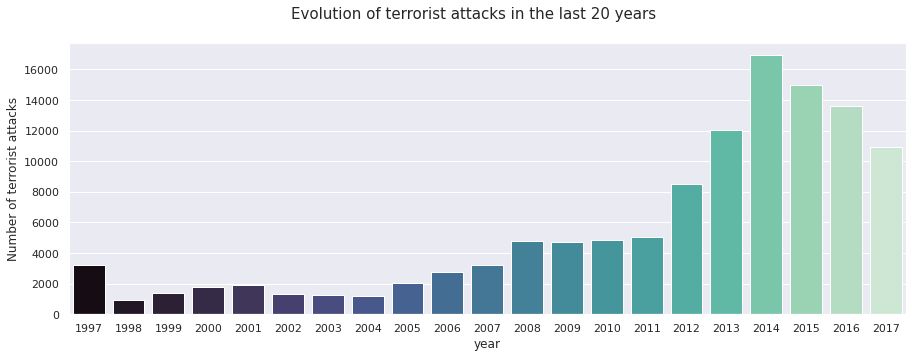

In [10]:
sns.set_theme()
sns.set(color_codes=True)

#Given that we already have the data grouped and the level of granularity is small enoguh to be handled by python, we are converting the dataframe to a pandas 
#dataframe in order to make easier the understansing of the data
Py_EventsPerYearDF = EventsPerYearDF.toPandas()

# Displaying a chart
fig, ax = plt.subplots(figsize=(15,5))

# Plotting the bar chart
ax = sns.barplot(x='year', y='NumEvents', data = Py_EventsPerYearDF, palette="mako")

# Adding titles
fig.suptitle('Evolution of terrorist attacks in the last 20 years', fontsize=15)
ax.set(ylabel = "Number of terrorist attacks")


#### What has been the increase from 1997 to 2017 in the number of terrorist attacks

In [11]:
y1997 = (EventsPerYearDF.filter(col("year") == 1997).select('NumEvents').collect())[0][0] #we do a collect because we know we are only extracting one row
y2017 = (EventsPerYearDF.filter(col("year") == 2017).select('NumEvents').collect())[0][0]

print('The number of terrorist attacks has increased a','{0:.0f}%'.format(((y2017-y1997)/y1997)*100),'since 1997, compared to a 28% increase in the population for the same years')

The number of terrorist attacks has increased a 241% since 1997, compared to a 28% increase in the population for the same years


* Sadly, even though there are fluctuations in the number of terrorist attacks from year to year, in some cases increasing with respect to the previous year and in some cases decreasing, the overall trend is upward given that on 66% of the years there was an increase in terrorist attacks
* However, there seems to be some hope, given that from the year 2014 and onwards we are seeing a decrease in the number of attacks, that hopefully keeps decreasing through out the years
* Finally, we observe an increase of 1574%, when comparing the number of terrorist attacks in 1970 against the last registered year (2017). And increase of 240% when compared to 2007. A percentage increase that is above the increase in the world population
* We must take this numbers with a grain of salt though. Over the years, as the world as become more connected, the collection of information and its quality have improved substantially, so we should be aware that this data might not be telling us the whole true and it is possible that in previous years there were more terrorist attacks of those registered.


### 4.2. How have terrorist attacks evolved in the past 20 years in each region?
<a id='4.2'></a>

In [13]:
#Group the dataset by years and region, counting the number of terrorist events per year. 
EventsYearRegionDF = (
                    TerrorismDF.select("year","region","eventid")
                     .groupBy("year","region")
                     .agg(count("eventid").alias("NumEvents"))
                     .orderBy("year","region")
                    )


#Create a window by region and year.
my_window1 = Window.partitionBy('region').orderBy("year")
my_window4 = Window.partitionBy().orderBy("year")

#For each year and region, the number of terrorist attacks from the previous year is brought, in order to be able to compute the evolution in the following statement.
#Then, for each year, the total number of terrorists attacks in each year is brought, to understand how much the number of terrorist attacks of each region accounts in the total of terrorist attacks
EventsYearRegionDF = EventsYearRegionDF\
                        .withColumn('prev_year', f.lag(EventsYearRegionDF.NumEvents).over(my_window1))\
                        .withColumn('TotalYear', f.sum(EventsYearRegionDF.NumEvents).over(my_window4))


#compute for each region and year, the increase/decrease in the number of attacks
#Compute for each year, the weight each region's number of attacks have in the total number of attacks.
EventsYearRegionDF = EventsYearRegionDF\
                                .withColumn("%YearlyChange", round(((EventsYearRegionDF.NumEvents-EventsYearRegionDF.prev_year)/EventsYearRegionDF.prev_year)*100,2))\
                                .withColumn("%OfYear", round((EventsYearRegionDF.NumEvents/EventsYearRegionDF.TotalYear)*100,2))
                                    

EventsYearRegionDF.sort('year').show()

+----+--------------------+---------+---------+---------+-------------+-------+
|year|              region|NumEvents|prev_year|TotalYear|%YearlyChange|%OfYear|
+----+--------------------+---------+---------+---------+-------------+-------+
|1997|        Central Asia|       49|     null|     3197|         null|   1.53|
|1997|Central America &...|      117|     null|     3197|         null|   3.66|
|1997|  Sub-Saharan Africa|      279|     null|     3197|         null|   8.73|
|1997|      Western Europe|      349|     null|     3197|         null|  10.92|
|1997|Middle East & Nor...|      548|     null|     3197|         null|  17.14|
|1997|       North America|      137|     null|     3197|         null|   4.29|
|1997|Australasia & Oce...|        7|     null|     3197|         null|   0.22|
|1997|       South America|      774|     null|     3197|         null|  24.21|
|1997|           East Asia|       40|     null|     3197|         null|   1.25|
|1997|          South Asia|      490|   

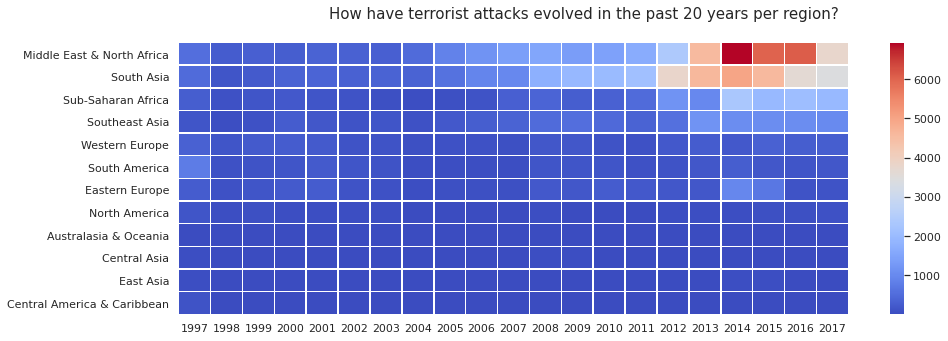

In [14]:
%matplotlib inline 

#Given that we already have the data grouped and the level of detailed is small enoguh to be handled by python, we are converting the dataframe to a pandas 
#dataframe in order to make easier the understansing of the data
Py_EventsYearRegionDF = EventsYearRegionDF.toPandas()
Py_EventsYearRegionDF.set_index("year", inplace = True)

#creates a pivot table with Year in row and Race in columns, counting the values for each combination
df_pivot_temp1 = Py_EventsYearRegionDF.pivot_table(values = 'NumEvents', index = 'region', columns = 'year' , aggfunc = 'sum', fill_value = 0) 
df_pivot_temp1 = df_pivot_temp1.sort_values([2017], ascending=False)

fig, ax = plt.subplots(figsize=(15, 5)) 
g = sns.heatmap(df_pivot_temp1,cmap="coolwarm",linewidths=.5,vmin=0.01)

# Adding titles
fig.suptitle('How have terrorist attacks evolved in the past 20 years per region?', fontsize=15)
# Remove labels beause the values are self explanatory.
ax.set_ylabel('')    
ax.set_xlabel('')

plt.show()

#### Detailed view of the behaviour of the attacks per Region, to make sure we are not missing something insteresting due to the dimension of the biggest regions

Text(0.5, 1.0, 'South America')

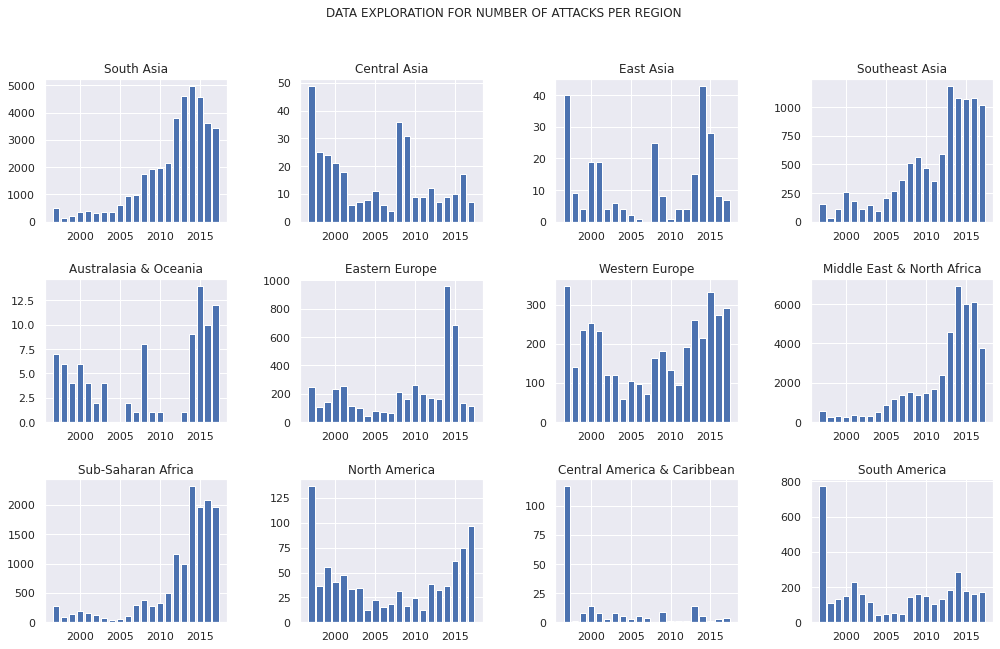

In [15]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12)) = plt.subplots(3, 4, figsize = (17, 10), sharex=False, sharey = False)

fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('DATA EXPLORATION FOR NUMBER OF ATTACKS PER REGION')

#create a barchart per region showing the number of attacks per year

ax1.bar(Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='South Asia'].index, Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='South Asia']['NumEvents'])
ax1.set_title('South Asia')

ax2.bar(Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Central Asia'].index, Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Central Asia']['NumEvents'])
ax2.set_title('Central Asia')

ax3.bar(Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='East Asia'].index, Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='East Asia']['NumEvents'])
ax3.set_title('East Asia')

ax4.bar(Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Southeast Asia'].index, Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Southeast Asia']['NumEvents'])
ax4.set_title('Southeast Asia')

ax5.bar(Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Australasia & Oceania'].index, Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Australasia & Oceania']['NumEvents'])
ax5.set_title('Australasia & Oceania')

ax6.bar(Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Eastern Europe'].index, Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Eastern Europe']['NumEvents'])
ax6.set_title('Eastern Europe')

ax7.bar(Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Western Europe'].index, Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Western Europe']['NumEvents'])
ax7.set_title('Western Europe')

ax8.bar(Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Middle East & North Africa'].index, Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Middle East & North Africa']['NumEvents'])
ax8.set_title('Middle East & North Africa')

ax9.bar(Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Sub-Saharan Africa'].index, Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Sub-Saharan Africa']['NumEvents'])
ax9.set_title('Sub-Saharan Africa')

ax10.bar(Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='North America'].index, Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='North America']['NumEvents'])
ax10.set_title('North America')

ax11.bar(Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Central America & Caribbean'].index, Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='Central America & Caribbean']['NumEvents'])
ax11.set_title('Central America & Caribbean')

ax12.bar(Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='South America'].index, Py_EventsYearRegionDF[Py_EventsYearRegionDF["region"]=='South America']['NumEvents'])
ax12.set_title('South America')

    

#### Contribution per Region to the total number of terrorist attacks

In [438]:
#Group the dataset by region, counting the total number of terrorist events
ContPerRegionDF = (
                    EventsYearRegionDF.select('region','NumEvents')
                     .groupBy('region')
                     .agg(sum('NumEvents').alias('NumEvents'))
                     .orderBy('region')
                    )

my_window4 = Window.partitionBy().orderBy()

#Bring for every rwo the total number of terrorist attacks 
ContPerRegionDF = ContPerRegionDF\
                        .withColumn('TotalYear', f.sum(ContPerRegionDF.NumEvents).over(my_window4))

#compute how much does each region represent in the total number of terrorist attacks
ContPerRegionDF = ContPerRegionDF\
                                .withColumn("%", round((ContPerRegionDF.NumEvents/ContPerRegionDF.TotalYear)*100,2))


ContPerRegionDF.sort('%').show()

+--------------------+---------+---------+-----+
|              region|NumEvents|TotalYear|    %|
+--------------------+---------+---------+-----+
|Australasia & Oce...|       92|   117381| 0.08|
|Central America &...|      215|   117381| 0.18|
|           East Asia|      251|   117381| 0.21|
|        Central Asia|      326|   117381| 0.28|
|       North America|      878|   117381| 0.75|
|       South America|     3524|   117381|  3.0|
|      Western Europe|     3926|   117381| 3.34|
|      Eastern Europe|     4504|   117381| 3.84|
|      Southeast Asia|     9860|   117381|  8.4|
|  Sub-Saharan Africa|    13553|   117381|11.55|
|          South Asia|    38063|   117381|32.43|
|Middle East & Nor...|    42189|   117381|35.94|
+--------------------+---------+---------+-----+



#### Contribution of Middle East & North Africa in the number of terrorist attacks each year

In [448]:
#Filter the dataset only for middle east & North Africa
EventsYearRegionDF.filter(EventsYearRegionDF.region == 'Middle East & North Africa').show(100)

+----+--------------------+---------+---------+---------+-------------+-------+
|year|              region|NumEvents|prev_year|TotalYear|%YearlyChange|%OfYear|
+----+--------------------+---------+---------+---------+-------------+-------+
|1997|Middle East & Nor...|      548|     null|     3197|         null|  17.14|
|1998|Middle East & Nor...|      247|      548|     4131|       -54.93|   5.98|
|1999|Middle East & Nor...|      316|      247|     5526|        27.94|   5.72|
|2000|Middle East & Nor...|      272|      316|     7340|       -13.92|   3.71|
|2001|Middle East & Nor...|      362|      272|     9246|        33.09|   3.92|
|2002|Middle East & Nor...|      326|      362|    10579|        -9.94|   3.08|
|2003|Middle East & Nor...|      310|      326|    11857|        -4.91|   2.61|
|2004|Middle East & Nor...|      492|      310|    13023|        58.71|   3.78|
|2005|Middle East & Nor...|      882|      492|    15040|        79.27|   5.86|
|2006|Middle East & Nor...|     1187|   

#### Contribution of South Asian in the number of terrorist attacks each year

In [17]:
#Filter the dataset only for South Asia
EventsYearRegionDF.filter(EventsYearRegionDF.region == 'South Asia').show(100)

+----+----------+---------+---------+---------+-------------+-------+
|year|    region|NumEvents|prev_year|TotalYear|%YearlyChange|%OfYear|
+----+----------+---------+---------+---------+-------------+-------+
|1997|South Asia|      490|     null|     3197|         null|  15.33|
|1998|South Asia|      136|      490|     4131|       -72.24|   3.29|
|1999|South Asia|      225|      136|     5526|        65.44|   4.07|
|2000|South Asia|      357|      225|     7340|        58.67|   4.86|
|2001|South Asia|      385|      357|     9246|         7.84|   4.16|
|2002|South Asia|      334|      385|    10579|       -13.25|   3.16|
|2003|South Asia|      353|      334|    11857|         5.69|   2.98|
|2004|South Asia|      369|      353|    13023|         4.53|   2.83|
|2005|South Asia|      604|      369|    15040|        63.69|   4.02|
|2006|South Asia|      938|      604|    17798|         55.3|   5.27|
|2007|South Asia|      982|      938|    21040|         4.69|   4.67|
|2008|South Asia|   

* Middle east & North Africa accounted for a 36% of the total number of terrorist attacks in the last 20 years. And specifically, in the years 2013, 2014, 2015 and 2016, accounting for percentages above 5%, of the total amount of number attacks in each of the Years. A percentage considerable higher compare to other regions, except south Asia.
* South Asia accounted for a 32% of the total number of terrorist attacks in the last 20 years. Being the years 2012, 2013 and 2014 one of the highest.
* The only region that seems to have reached sort of more peaceful time in the last 20 years, has been Central Asia. However, it is worth noting that all the regions, except North America, seem to be having a downward trend from 2015 and on. 
* It would be worthwhile, then, in future analyzes to delve into the causes of this drop in the number of terrorist attacks

### 4.3. Throughout the years, does it seem to have been a switch in the type of attacks the world has experienced?
<a id='4.3'></a>

In [20]:
#Group the dataset by year and attack type, counting the number of terrorist events for each group. 
EventsYearAttackDF = (
                    TerrorismDF.select("year","AttackType","eventid")
                     .groupBy("year","AttackType")
                     .agg(count("eventid").alias("NumEvents"))
                     .orderBy("year","AttackType")
                    )


my_window2 = Window.partitionBy('year').orderBy("year")

#Bring for every combination of attack type and year the total number of attacks in each year. To be able to compare how much does each attack type
#weights againts the total number of attacks for each year.
EventsYearAttackDF = EventsYearAttackDF\
                        .withColumn('TotalAttackType', f.sum(EventsYearAttackDF.NumEvents).over(my_window2))

#compute how much each attack type weights for each year
EventsYearAttackDF = EventsYearAttackDF\
                                .withColumn("%", round((EventsYearAttackDF.NumEvents/EventsYearAttackDF.TotalAttackType)*100,2))



EventsYearAttackDF.show()


+----+--------------------+---------+---------------+-----+
|year|          AttackType|NumEvents|TotalAttackType|    %|
+----+--------------------+---------+---------------+-----+
|2003|       Armed Assault|      315|           1278|24.65|
|2003|       Assassination|       88|           1278| 6.89|
|2003|   Bombing/Explosion|      689|           1278|53.91|
|2003|Facility/Infrastr...|       88|           1278| 6.89|
|2003|           Hijacking|        3|           1278| 0.23|
|2003|Hostage Taking (B...|        2|           1278| 0.16|
|2003|Hostage Taking (K...|       46|           1278|  3.6|
|2003|     Unarmed Assault|       20|           1278| 1.56|
|2003|             Unknown|       27|           1278| 2.11|
|2007|       Armed Assault|      849|           3242|26.19|
|2007|       Assassination|      140|           3242| 4.32|
|2007|   Bombing/Explosion|     1866|           3242|57.56|
|2007|Facility/Infrastr...|      115|           3242| 3.55|
|2007|           Hijacking|        7|   

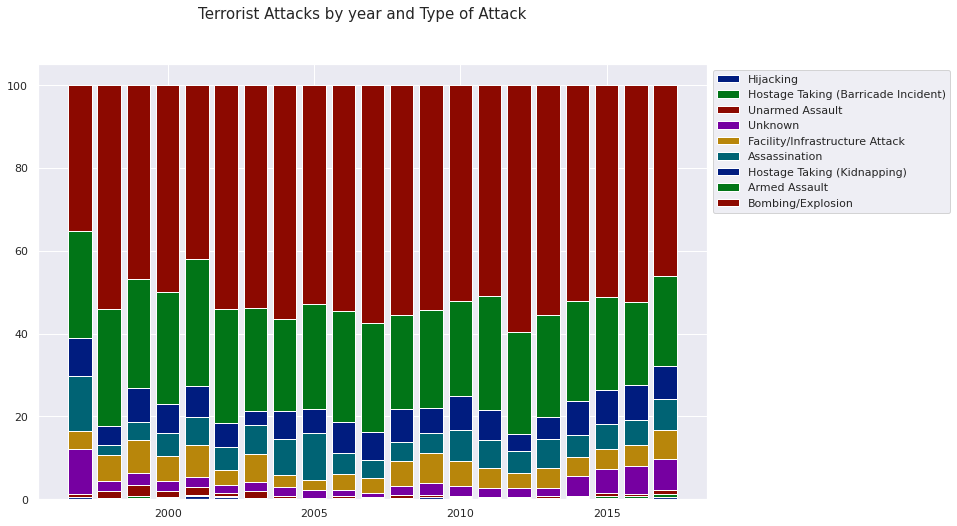

In [21]:
#the dataframe EventsYearAttackDF only has 187 rows, so there is no problem in converting it to a pandas dataframe 
Py_EventsYearAttackDF = EventsYearAttackDF.toPandas()

#creates a pivot table with Year in row and attacktype in columns, counting the values for each combination
df_pivot_temp3 = Py_EventsYearAttackDF.pivot_table(values = '%', index = 'year', columns = 'AttackType' , aggfunc = 'sum', fill_value = 0) 

# We are creating a stackedbar chart by region, attacktype and % of terrorist attacks

plt.style.use('seaborn-dark-palette')

%matplotlib inline
fig, ax = plt.subplots(
        figsize = (12,8)
)
# Adding title
fig.suptitle('Terrorist Attacks by year and Type of Attack', fontsize = 15)

# Ploting the bar chart, sequentially stacking each attack type
ax.bar(df_pivot_temp3.index, df_pivot_temp3['Hijacking'], label = 'Hijacking')

ax.bar(df_pivot_temp3.index, df_pivot_temp3['Hostage Taking (Barricade Incident)'], 
       bottom =   df_pivot_temp3['Hijacking'],label = 'Hostage Taking (Barricade Incident)')

ax.bar(df_pivot_temp3.index, df_pivot_temp3['Unarmed Assault'], 
       bottom = df_pivot_temp3['Hostage Taking (Barricade Incident)']
       + df_pivot_temp3['Hijacking'], label = 'Unarmed Assault')

ax.bar(df_pivot_temp3.index, df_pivot_temp3['Unknown'], 
       bottom = df_pivot_temp3['Unarmed Assault']
       + df_pivot_temp3['Hostage Taking (Barricade Incident)']
       + df_pivot_temp3['Hijacking'], label = 'Unknown')

ax.bar(df_pivot_temp3.index, df_pivot_temp3['Facility/Infrastructure Attack'], 
       bottom = df_pivot_temp3['Unknown']
       + df_pivot_temp3['Unarmed Assault']
       + df_pivot_temp3['Hostage Taking (Barricade Incident)']
       + df_pivot_temp3['Hijacking'], label = 'Facility/Infrastructure Attack')

ax.bar(df_pivot_temp3.index, df_pivot_temp3['Assassination'], 
       bottom = df_pivot_temp3['Facility/Infrastructure Attack']
       + df_pivot_temp3['Unknown']
       + df_pivot_temp3['Unarmed Assault']
       + df_pivot_temp3['Hostage Taking (Barricade Incident)']
       + df_pivot_temp3['Hijacking'], label = 'Assassination')

ax.bar(df_pivot_temp3.index, df_pivot_temp3['Hostage Taking (Kidnapping)'], 
       bottom = df_pivot_temp3['Assassination']
       + df_pivot_temp3['Facility/Infrastructure Attack']
       + df_pivot_temp3['Unknown']
       + df_pivot_temp3['Unarmed Assault']
       + df_pivot_temp3['Hostage Taking (Barricade Incident)']
       + df_pivot_temp3['Hijacking'], label = 'Hostage Taking (Kidnapping)')

ax.bar(df_pivot_temp3.index, df_pivot_temp3['Armed Assault'], 
       bottom = df_pivot_temp3['Hostage Taking (Kidnapping)']
       + df_pivot_temp3['Assassination']
       + df_pivot_temp3['Facility/Infrastructure Attack']
       + df_pivot_temp3['Unknown']
       + df_pivot_temp3['Unarmed Assault']
       + df_pivot_temp3['Hostage Taking (Barricade Incident)']
       + df_pivot_temp3['Hijacking'], label = 'Armed Assault')

ax.bar(df_pivot_temp3.index, df_pivot_temp3['Bombing/Explosion'], 
       bottom = df_pivot_temp3['Armed Assault'] 
       + df_pivot_temp3['Hostage Taking (Kidnapping)']
       + df_pivot_temp3['Assassination']
       + df_pivot_temp3['Facility/Infrastructure Attack']
       + df_pivot_temp3['Unknown']
       + df_pivot_temp3['Unarmed Assault']
       + df_pivot_temp3['Hostage Taking (Barricade Incident)']
       + df_pivot_temp3['Hijacking'], label = 'Bombing/Explosion')

ax.legend(bbox_to_anchor=(1,1),frameon=True, loc='upper left')

* When looking at the type of attacks through out the years, there doesn’t seem to be notorious change in the type of attacks the terrorism use. Which can lead us to think that so far, Bombing and explosions, have been the most effective way of terrorizing the population, followed by armed assaults.

### 4.4. Have attacks become more lethal?
<a id='4.4'></a>

In [23]:
# Create a new data frame from the dataframe TerrorismDF and adding a new columns that inform if the number of wounded or killed in an attacks is unknown
KillWoundedDF = TerrorismDF\
   .withColumn('UnknownKillWound', when(col('nkill').isNull() | col('nWound').isNull() ,1 )
                                  .otherwise(0))


#### Number of fatalities/wounded years after year due to terrorist attacks

In [24]:
#Group the previous dataset summing per year, the number of fatalities, the number of wounded and if one of the previous two measures is unknown
KillWoundedDF_Sum = (
                     KillWoundedDF.select("year","nkill","nwound",'UnknownKillWound')
                     .groupBy("year")
                     .agg(sum("nkill").alias("Fatalities"),sum("nwound").alias("Wounded"), sum("UnknownKillWound").alias("Unknown"))
                     .orderBy("year")
                    )

#Calculate the total number of people affected by the terrorist attack, either because they were killed or injured
KillWoundedDF_Sum = KillWoundedDF_Sum \
                                .withColumn("Total", (KillWoundedDF_Sum.Fatalities + KillWoundedDF_Sum.Wounded))

#Bring from the dataframe EventsPerYearDF the total number of attacks for each year.
KillWoundedDF_Sum = KillWoundedDF_Sum.\
                    join(EventsPerYearDF, KillWoundedDF_Sum.year == EventsPerYearDF.year, how='left')\
                    .select(KillWoundedDF_Sum.year,KillWoundedDF_Sum.Fatalities,KillWoundedDF_Sum.Wounded,KillWoundedDF_Sum.Unknown,KillWoundedDF_Sum.Total,EventsPerYearDF.NumEvents)
                   
#calculate on average how many people were killed and many people were wounded on each attack
KillWoundedDF_Sum = KillWoundedDF_Sum \
                                .withColumn("AverageFatalities", (KillWoundedDF_Sum.Fatalities / KillWoundedDF_Sum.NumEvents))\
                                .withColumn("AverageWounded", (KillWoundedDF_Sum.Wounded / KillWoundedDF_Sum.NumEvents))


KillWoundedDF_Sum.sort('year').show(30)

+----+----------+-------+-------+-------+---------+------------------+------------------+
|year|Fatalities|Wounded|Unknown|  Total|NumEvents| AverageFatalities|    AverageWounded|
+----+----------+-------+-------+-------+---------+------------------+------------------+
|1997|     10924| 9072.0|    203|19996.0|     3197| 3.416953393806694|2.8376603065373787|
|1998|      4688| 8183.0|    152|12871.0|      934| 5.019271948608137| 8.761241970021413|
|1999|      3393| 5341.0|    114| 8734.0|     1395| 2.432258064516129| 3.828673835125448|
|2000|      4403| 5869.0|    170|10272.0|     1814|2.4272326350606397|3.2353914002205073|
|2001|      7729|22774.0|    109|30503.0|     1906| 4.055089192025184|11.948583420776496|
|2002|      4805| 7162.0|     87|11967.0|     1333| 3.604651162790698| 5.372843210802701|
|2003|      3317| 7384.0|    104|10701.0|     1278|2.5954616588419404| 5.777777777777778|
|2004|      5743|12022.0|    116|17765.0|     1166| 4.925385934819897|10.310463121783876|
|2005|    

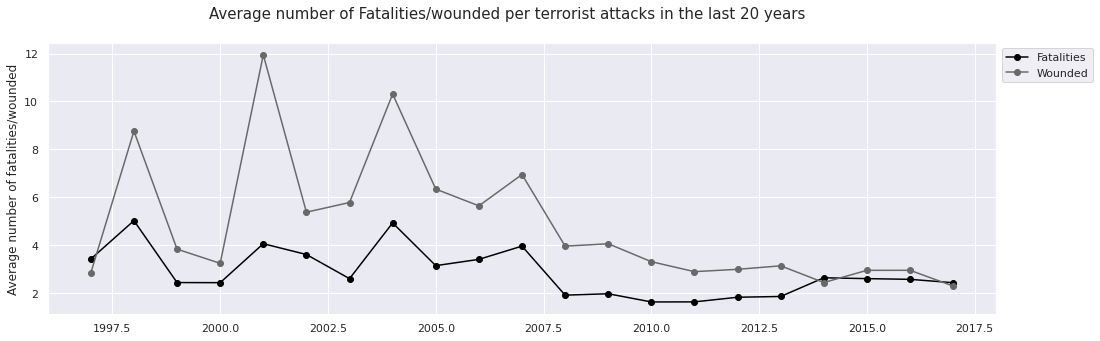

In [276]:
#Convert the previous dataframe to pandas
Py_KillWoundedDF_Sum = KillWoundedDF_Sum.toPandas()
Py_KillWoundedDF_Sum = Py_KillWoundedDF_Sum.sort_values(by='year')

# Displaying a bar chart
fig, ax = plt.subplots(figsize=(17,5))

# Adding titles
fig.suptitle('Average number of Fatalities/wounded per terrorist attacks in the last 20 years', fontsize=15)
ax.set_ylabel("Average number of fatalities/wounded")

# Plotting the bar chart
ax.plot(Py_KillWoundedDF_Sum['year'], Py_KillWoundedDF_Sum['AverageFatalities'],color='black',label ='Fatalities', marker ='o')
ax.plot(Py_KillWoundedDF_Sum['year'], Py_KillWoundedDF_Sum['AverageWounded'],color='dimgrey', label ='Wounded',marker ='o')

ax.legend(bbox_to_anchor=(1,1),frameon=True, loc='upper left')


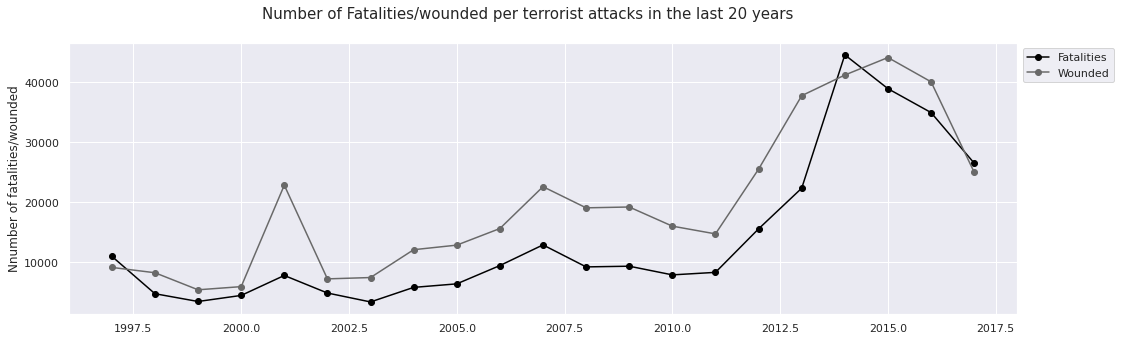

In [277]:
# Displaying a bar chart
fig, ax = plt.subplots(figsize=(17,5))

# Adding titles
fig.suptitle('Number of Fatalities/wounded per terrorist attacks in the last 20 years', fontsize=15)
ax.set_ylabel("Nnumber of fatalities/wounded")

# Plotting the bar chart
ax.plot(Py_KillWoundedDF_Sum['year'], Py_KillWoundedDF_Sum['Fatalities'],color='black',label ='Fatalities', marker ='o')
ax.plot(Py_KillWoundedDF_Sum['year'], Py_KillWoundedDF_Sum['Wounded'],color='dimgrey', label ='Wounded',marker ='o')

ax.legend(bbox_to_anchor=(1,1),frameon=True, loc='upper left')

#### Number of fatalities/wounded year after year due to terrorist attacks per regions

In [25]:
#Count by region and by year the number of people wounded, the number of people killed and if there are unknown killed or wounded people
KillWoundedDF_Region = (
                     KillWoundedDF.select("year",'region',"nkill","nwound",'UnknownKillWound')
                     .groupBy("year",'region')
                     .agg(sum("nkill").alias("Fatalities"),sum("nwound").alias("Wounded"), sum("UnknownKillWound").alias("Unknown"))
                     .orderBy("year")
                    )

#calculate by region the total number of people affected by the attacks
KillWoundedDF_Region = KillWoundedDF_Region \
                                .withColumn("Total", (KillWoundedDF_Region.Fatalities + KillWoundedDF_Region.Wounded))


KillWoundedDF_Region.sort('year').show(30)

+----+--------------------+----------+-------+-------+------+
|year|              region|Fatalities|Wounded|Unknown| Total|
+----+--------------------+----------+-------+-------+------+
|1997|Middle East & Nor...|      4691| 2582.0|      8|7273.0|
|1997|  Sub-Saharan Africa|      2188| 1390.0|      0|3578.0|
|1997|           East Asia|        38|  118.0|      0| 156.0|
|1997|       South America|      1317|  756.0|     70|2073.0|
|1997|Australasia & Oce...|         0|   23.0|      0|  23.0|
|1997|       North America|       231|   66.0|      0| 297.0|
|1997|      Eastern Europe|       115|  291.0|      0| 406.0|
|1997|        Central Asia|        81|   47.0|      0| 128.0|
|1997|Central America &...|        73|  135.0|      0| 208.0|
|1997|      Southeast Asia|       335|  690.0|      0|1025.0|
|1997|      Western Europe|        40|   95.0|     27| 135.0|
|1997|          South Asia|      1815| 2879.0|     98|4694.0|
|1998|      Eastern Europe|       109|  164.0|     19| 273.0|
|1998|Mi

#### A heatmap chart to help compare if number of terrorist attacks per region, and the number of fatalities+wounded per region

Text(0.5, 1.0, 'Number of Attacks')

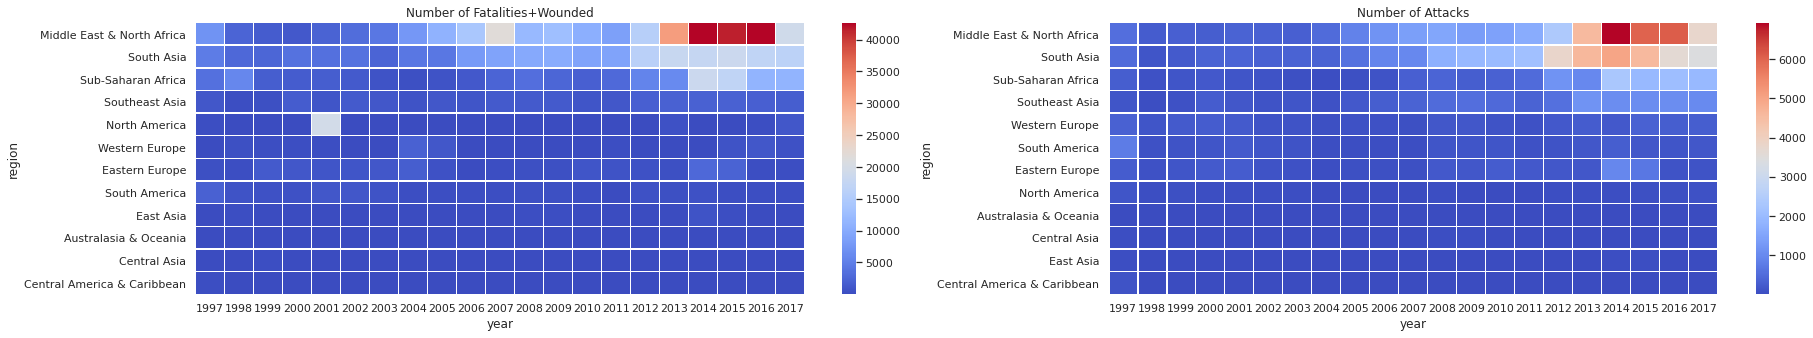

In [32]:
#Convert the previous dataframe to pandas
Py_KillWoundedDF_Region = KillWoundedDF_Region.toPandas()
Py_KillWoundedDF_Region.set_index("year", inplace = True)

#Convert to a pivot table the dataframe, setting the region as the index and the columns the years. So we can see how have the attacks evolved per region
df_pivot_temp4 = Py_KillWoundedDF_Region.pivot_table(values = 'Total', index = 'region', columns = 'year' , aggfunc = 'sum', fill_value = 0) #creates a pivot table with Year in row and Race in columns, counting the values for each combination
df_pivot_temp4 = df_pivot_temp4.sort_values([2017], ascending=False)

# Create to subplots
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize = (30, 5), sharex=False, sharey = False)

#The first subplot is going to shown the average number of fatalities +  wounded per attack
ax1 = sns.heatmap(df_pivot_temp4,cmap="coolwarm",linewidths=.5,vmin=0.01, ax=ax1)
ax1.set_title('Number of Fatalities+Wounded')
#The second subplot is going to show the number of attacks per region
ax2 = sns.heatmap(df_pivot_temp1,cmap="coolwarm",linewidths=.5,vmin=0.01, ax=ax2)
ax2.set_title('Number of Attacks')

* The number of fatalities and wounded throughout the years has been increasing as expected, because the number of attacks has been increasing as well. However, when calculating the average number of fatalities and wounded per attack, we realize that they have been steadily decreasing. We could speculate then, that even though the number of attacks have increase through the years, the vigilance and security of each region has been improving, therefor an event that could cause havoc before, nowadays are not possible to execute due to security measures and terrorist groups have been force to resort to attacks of less magnitude.

### 4.5. Do different regions have different type of attack?
<a id='4.5'></a>

In [34]:
#Group the information by region an attack type.
AttacksRegionDF = (
                    TerrorismDF.select('region','AttackType','eventid')
                     .groupBy('region','AttackType')
                     .agg(count("eventid").alias("NumEvents"))
                     .orderBy('region','AttackType')
                    )

my_window3 = Window.partitionBy('region').orderBy('region')

#Bring for every row the total number of attacks per region
AttacksRegionDF = AttacksRegionDF.withColumn('TotalRegion', f.sum(AttacksRegionDF.NumEvents).over(my_window3))

#Compute how much does each attack type represents in the total number of attacks each region had
AttacksRegionDF = AttacksRegionDF.withColumn("%", AttacksRegionDF.NumEvents/AttacksRegionDF.TotalRegion)

AttacksRegionDF.sort('AttackType').show()

+--------------------+-------------+---------+-----------+--------------------+
|              region|   AttackType|NumEvents|TotalRegion|                   %|
+--------------------+-------------+---------+-----------+--------------------+
|       South America|Armed Assault|      647|       3524| 0.18359818388195231|
|Middle East & Nor...|Armed Assault|     7467|      42189|  0.1769892626039963|
|Central America &...|Armed Assault|       72|        215| 0.33488372093023255|
|       North America|Armed Assault|      186|        878| 0.21184510250569477|
|        Central Asia|Armed Assault|       67|        326| 0.20552147239263804|
|           East Asia|Armed Assault|       57|        251| 0.22709163346613545|
|          South Asia|Armed Assault|     9333|      38063| 0.24519874944171505|
|      Eastern Europe|Armed Assault|     1170|       4504| 0.25976909413854354|
|Australasia & Oce...|Armed Assault|       11|         92| 0.11956521739130435|
|      Western Europe|Armed Assault|    

#### Analyze using a stacked bar chart how much each attack type represents in the total number of attacks of each region.

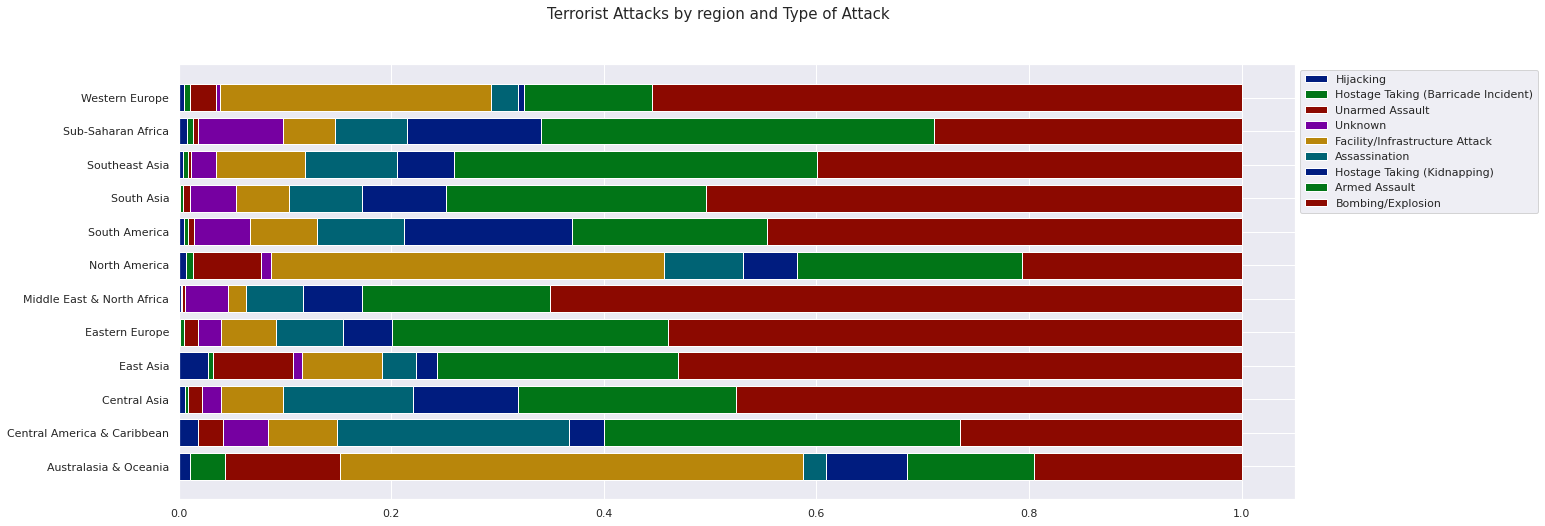

In [35]:
Py_AttacksRegionDF = AttacksRegionDF.toPandas()

df_pivot_temp5 = Py_AttacksRegionDF.pivot_table(values = '%', index = 'region', columns = 'AttackType' , aggfunc = 'sum', fill_value = 0) #creates a pivot table with Year in row and Race in columns, counting the values for each combination


plt.style.use('seaborn-dark-palette')

%matplotlib inline
fig, ax = plt.subplots(
        figsize = (20,8)
)
# Adding title
fig.suptitle('Terrorist Attacks by region and Type of Attack', fontsize = 15)

# Ploting the bar chart, sequentially stacking each attack type
ax.barh(df_pivot_temp5.index, df_pivot_temp5['Hijacking'], label = 'Hijacking')

ax.barh(df_pivot_temp5.index, df_pivot_temp5['Hostage Taking (Barricade Incident)'], 
       left =   df_pivot_temp5['Hijacking'],label = 'Hostage Taking (Barricade Incident)')

ax.barh(df_pivot_temp5.index, df_pivot_temp5['Unarmed Assault'], 
       left = df_pivot_temp5['Hostage Taking (Barricade Incident)']
       + df_pivot_temp5['Hijacking'], label = 'Unarmed Assault')

ax.barh(df_pivot_temp5.index, df_pivot_temp5['Unknown'], 
       left = df_pivot_temp5['Unarmed Assault']
       + df_pivot_temp5['Hostage Taking (Barricade Incident)']
       + df_pivot_temp5['Hijacking'], label = 'Unknown')

ax.barh(df_pivot_temp5.index, df_pivot_temp5['Facility/Infrastructure Attack'], 
       left = df_pivot_temp5['Unknown']
       + df_pivot_temp5['Unarmed Assault']
       + df_pivot_temp5['Hostage Taking (Barricade Incident)']
       + df_pivot_temp5['Hijacking'], label = 'Facility/Infrastructure Attack')

ax.barh(df_pivot_temp5.index, df_pivot_temp5['Assassination'], 
       left = df_pivot_temp5['Facility/Infrastructure Attack']
       + df_pivot_temp5['Unknown']
       + df_pivot_temp5['Unarmed Assault']
       + df_pivot_temp5['Hostage Taking (Barricade Incident)']
       + df_pivot_temp5['Hijacking'], label = 'Assassination')

ax.barh(df_pivot_temp5.index, df_pivot_temp5['Hostage Taking (Kidnapping)'], 
       left = df_pivot_temp5['Assassination']
       + df_pivot_temp5['Facility/Infrastructure Attack']
       + df_pivot_temp5['Unknown']
       + df_pivot_temp5['Unarmed Assault']
       + df_pivot_temp5['Hostage Taking (Barricade Incident)']
       + df_pivot_temp5['Hijacking'], label = 'Hostage Taking (Kidnapping)')

ax.barh(df_pivot_temp5.index, df_pivot_temp5['Armed Assault'], 
       left = df_pivot_temp5['Hostage Taking (Kidnapping)']
       + df_pivot_temp5['Assassination']
       + df_pivot_temp5['Facility/Infrastructure Attack']
       + df_pivot_temp5['Unknown']
       + df_pivot_temp5['Unarmed Assault']
       + df_pivot_temp5['Hostage Taking (Barricade Incident)']
       + df_pivot_temp5['Hijacking'], label = 'Armed Assault')

ax.barh(df_pivot_temp5.index, df_pivot_temp5['Bombing/Explosion'], 
       left = df_pivot_temp5['Armed Assault'] 
       + df_pivot_temp5['Hostage Taking (Kidnapping)']
       + df_pivot_temp5['Assassination']
       + df_pivot_temp5['Facility/Infrastructure Attack']
       + df_pivot_temp5['Unknown']
       + df_pivot_temp5['Unarmed Assault']
       + df_pivot_temp5['Hostage Taking (Barricade Incident)']
       + df_pivot_temp5['Hijacking'], label = 'Bombing/Explosion')

ax.legend(bbox_to_anchor=(1,1),frameon=True, loc='upper left')


* When taking a closer look at the type of attack per region, we realize that, even though in most region bombing/attacking is the preferred way of attack, when we analyze North America we realize that it’s pattern is sort of different, being the Facility/infrastructure attacks the most used. This difference could indicate that the type of terrorism North America faces is completely different from the rest of the world and hence should be address from a completely different stand.

#### FINAL CONCLUSIONS

* The number of terrorist attacks has had a steady increase throughout the years, luckily there seems to be a decrease in the last 3 years. 
* The most affected regions are Middle East & North Africa and South Asia, but there are countries like North America with fewer number of attacks, but more lethal.
* On a good note, even though the number of attacks has increased, the effectiveness of them has decreased.
* Bombs and explosions seem to be the preferred method of the terrorist groups to attack the population.


# THE END, THANK YOU

## Eleonora Jiménez Pulido